In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler



In [ ]:
train_conv = pd.read_excel('train_conv.xlsx')
test_conv = pd.read_excel('test_conv.xlsx')
train_social = pd.read_excel('train_social.xlsx')
test_social = pd.read_excel('test_social.xlsx')

In [ ]:
def process_social_data(df):
    # Avoid division by zero: add a small number to dislikes
    df['Likes_Dislikes_Ratio'] = df['Likes'] / (df['Dislikes'] + 1e-8)
    df.drop(['Likes', 'Dislikes'], axis=1, inplace=True)
    return df


In [ ]:
# Process the train and test social data
train_social = process_social_data(train_social)
test_social = process_social_data(test_social)



In [ ]:
train_conv = train_conv.fillna(train_conv.median(numeric_only=True))
train_conv = train_conv.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'O' else x)
test_conv = test_conv.fillna(test_conv.median(numeric_only=True))
test_conv = test_conv.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == 'O' else x)
train_social = train_social.fillna(train_social.median())
test_social = test_social.fillna(test_social.median())

<ipython-input-14-a5667b279629>:5: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_social = train_social.fillna(train_social.median())
<ipython-input-14-a5667b279629>:6: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_social = test_social.fillna(test_social.median())


In [ ]:
encoder = OneHotEncoder(sparse=False)
train_conv_encoded = encoder.fit_transform(train_conv[['Genre', 'Sequel']])
test_conv_encoded = encoder.transform(test_conv[['Genre', 'Sequel']])

encoded_columns = encoder.get_feature_names_out(['Genre', 'Sequel'])
train_conv = pd.concat([train_conv.drop(['Genre', 'Sequel'], axis=1), pd.DataFrame(train_conv_encoded, columns=encoded_columns)], axis=1)
test_conv = pd.concat([test_conv.drop(['Genre', 'Sequel'], axis=1), pd.DataFrame(test_conv_encoded, columns=encoded_columns)], axis=1)



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Combine conventional and social media features
train_combined = pd.concat([train_conv, train_social.reset_index(drop=True)], axis=1)
test_combined = pd.concat([test_conv, test_social.reset_index(drop=True)], axis=1)

y_train_gross = train_conv['GrossLabel']
y_test_gross = test_conv['GrossLabel']
y_train_rating = train_conv['RatingLabel']
y_test_rating = test_conv['RatingLabel']



In [ ]:
# Drop labels from the combined datasets
train_conv = train_conv.drop(['GrossLabel', 'RatingLabel'], axis=1)
test_conv = test_conv.drop(['GrossLabel', 'RatingLabel'], axis=1)

train_social = train_social.drop(['GrossLabel', 'RatingLabel'], axis=1)
test_social = test_social.drop(['GrossLabel', 'RatingLabel'], axis=1)

train_combined = train_combined.drop(['GrossLabel', 'RatingLabel'], axis=1)
test_combined = test_combined.drop(['GrossLabel', 'RatingLabel'], axis=1)


gross_label_encoder = OneHotEncoder(sparse=False)
rating_label_encoder = OneHotEncoder(sparse=False)



In [ ]:
# Encode GrossLabel
y_train_gross_encoded = gross_label_encoder.fit_transform(y_train_gross.values.reshape(-1, 1))
y_test_gross_encoded = gross_label_encoder.transform(y_test_gross.values.reshape(-1, 1))

# Encode RatingLabel
y_train_rating_encoded = rating_label_encoder.fit_transform(y_train_rating.values.reshape(-1, 1))
y_test_rating_encoded = rating_label_encoder.transform(y_test_rating.values.reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_combined)
X_test_scaled = scaler.transform(test_combined)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


In [ ]:
# Implement LDA for 'GrossLabel'
lda_gross = LinearDiscriminantAnalysis(n_components=2)

lda_gross.fit(X_train_scaled, y_train_gross)
y_pred_lda_gross = lda_gross.predict(X_test_scaled)
accuracy_lda_gross = accuracy_score(y_test_gross, y_pred_lda_gross)

In [ ]:
# Encode the string labels to integers
label_encoder = LabelEncoder()
y_train_gross_encoded = label_encoder.fit_transform(y_train_gross)


In [ ]:
# Project the data onto the first two LDA components
X_lda = lda_gross.transform(X_train_scaled)


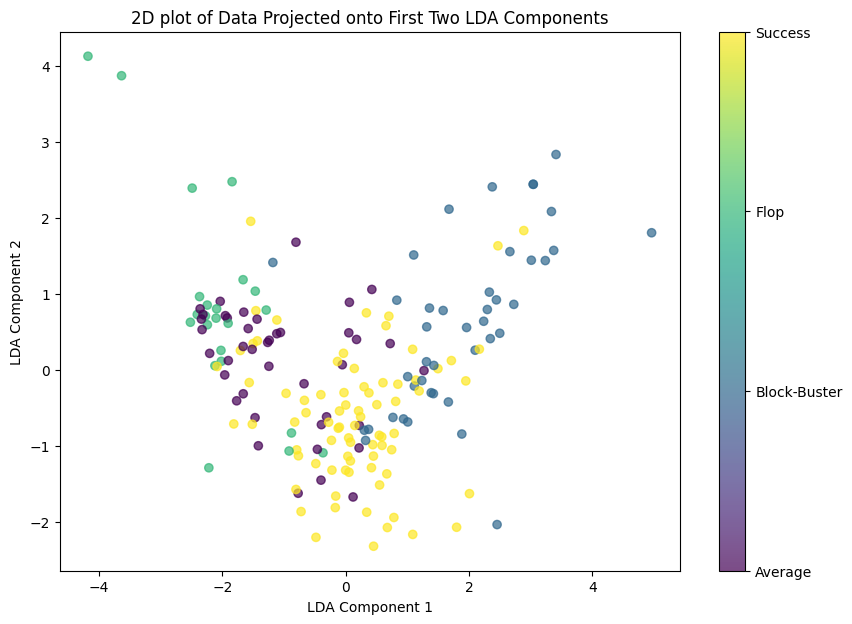

In [ ]:
# Now plot with the encoded labels
plt.figure(figsize=(10, 7))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_train_gross_encoded, cmap='viridis', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D plot of Data Projected onto First Two LDA Components')

# Create a color bar with the original string labels
cbar = plt.colorbar()
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)

plt.show()

In [ ]:
# Implement QDA for 'GrossLabel'
qda_gross = QuadraticDiscriminantAnalysis()
qda_gross.fit(X_train_scaled, y_train_gross)
y_pred_qda_gross = qda_gross.predict(X_test_scaled)
accuracy_qda_gross = accuracy_score(y_test_gross, y_pred_qda_gross)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Repeat for 'RatingLabel'
lda_rating = LinearDiscriminantAnalysis(n_components=2)
lda_rating.fit(X_train_scaled, y_train_rating)
y_pred_lda_rating = lda_rating.predict(X_test_scaled)
accuracy_lda_rating = accuracy_score(y_test_rating, y_pred_lda_rating)


In [ ]:
# Encode the string labels to integers
label_encoder = LabelEncoder()
y_train_gross_encoded = label_encoder.fit_transform(y_train_gross)


In [ ]:
# Project the data onto the first two LDA components
X_lda = lda_gross.transform(X_train_scaled)


In [ ]:
qda_rating = QuadraticDiscriminantAnalysis()
qda_rating.fit(X_train_scaled, y_train_rating)
y_pred_qda_rating = qda_rating.predict(X_test_scaled)
accuracy_qda_rating = accuracy_score(y_test_rating, y_pred_qda_rating)


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Print accuracies
print("LDA Accuracy for GrossLabel:", accuracy_lda_gross)
print("QDA Accuracy for GrossLabel:", accuracy_qda_gross)
print("LDA Accuracy for RatingLabel:", accuracy_lda_rating)
print("QDA Accuracy for RatingLabel:", accuracy_qda_rating)


LDA Accuracy for GrossLabel: 0.574468085106383
QDA Accuracy for GrossLabel: 0.3617021276595745
LDA Accuracy for RatingLabel: 0.3404255319148936
QDA Accuracy for RatingLabel: 0.3191489361702128


In [ ]:
# Classification reports
print("\nLDA Classification Report for GrossLabel:\n", classification_report(y_test_gross, y_pred_lda_gross))
print("\nQDA Classification Report for GrossLabel:\n", classification_report(y_test_gross, y_pred_qda_gross))
print("\nLDA Classification Report for RatingLabel:\n", classification_report(y_test_rating, y_pred_lda_rating))
print("\nQDA Classification Report for RatingLabel:\n", classification_report(y_test_rating, y_pred_qda_rating))


LDA Classification Report for GrossLabel:
               precision    recall  f1-score   support

     Average       0.38      0.62      0.48         8
Block-Buster       0.80      0.80      0.80        10
        Flop       0.50      0.33      0.40         6
     Success       0.60      0.52      0.56        23

    accuracy                           0.57        47
   macro avg       0.57      0.57      0.56        47
weighted avg       0.59      0.57      0.58        47


QDA Classification Report for GrossLabel:
               precision    recall  f1-score   support

     Average       0.14      0.38      0.20         8
Block-Buster       0.50      0.70      0.58        10
        Flop       0.00      0.00      0.00         6
     Success       0.64      0.30      0.41        23

    accuracy                           0.36        47
   macro avg       0.32      0.34      0.30        47
weighted avg       0.44      0.36      0.36        47


LDA Classification Report for RatingLabel

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

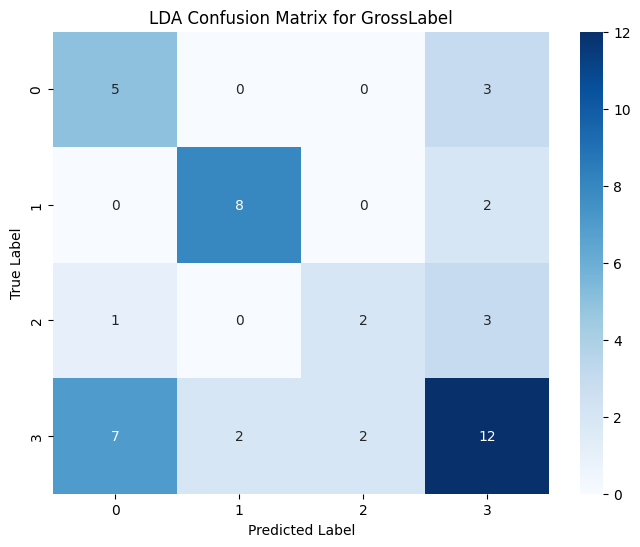

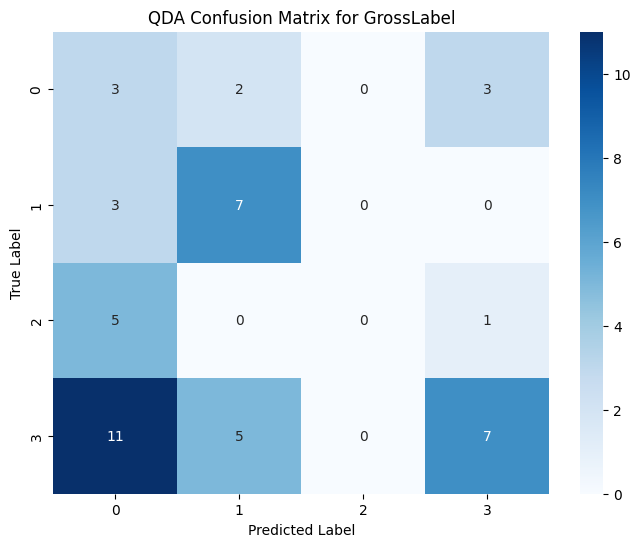

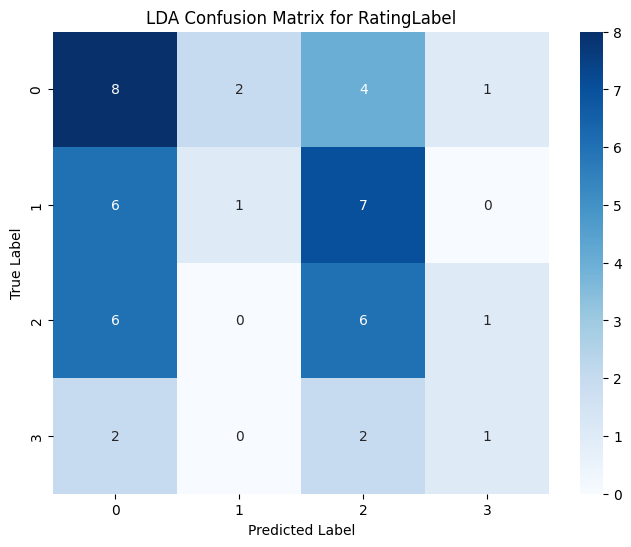

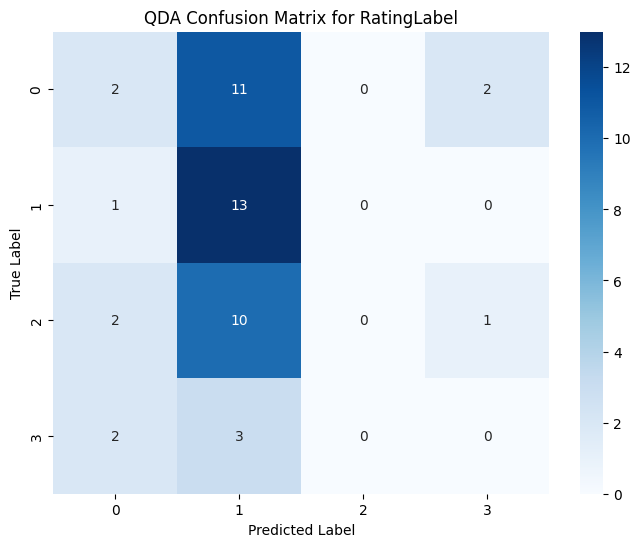

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



# Plot confusion matrices for LDA and QDA for GrossLabel
plot_confusion_matrix(y_test_gross, y_pred_lda_gross, 'LDA Confusion Matrix for GrossLabel')
plot_confusion_matrix(y_test_gross, y_pred_qda_gross, 'QDA Confusion Matrix for GrossLabel')

# Plot confusion matrices for LDA and QDA for RatingLabel
plot_confusion_matrix(y_test_rating, y_pred_lda_rating, 'LDA Confusion Matrix for RatingLabel')
plot_confusion_matrix(y_test_rating, y_pred_qda_rating, 'QDA Confusion Matrix for RatingLabel')


In [ ]:
# Function to train and evaluate LDA and QDA
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred_lda = lda.predict(X_test)
    accuracy_lda = accuracy_score(y_test, y_pred_lda)

    # QDA
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    y_pred_qda = qda.predict(X_test)
    accuracy_qda = accuracy_score(y_test, y_pred_qda)

    return accuracy_lda, accuracy_qda

In [ ]:
scaler = StandardScaler()
train_conv_scaled = scaler.fit_transform(train_conv)
test_conv_scaled = scaler.transform(test_conv)

In [ ]:
scaler = StandardScaler()
train_social_scaled = scaler.fit_transform(train_social)
test_social_scaled = scaler.transform(test_social)

In [ ]:
# Label encoding the target variables
label_encoder_gross = LabelEncoder()
y_train_gross_int = label_encoder_gross.fit_transform(y_train_gross)
y_test_gross_int = label_encoder_gross.transform(y_test_gross)

label_encoder_rating = LabelEncoder()
y_train_rating_int = label_encoder_rating.fit_transform(y_train_rating)
y_test_rating_int = label_encoder_rating.transform(y_test_rating)


In [ ]:
# Evaluate for conventional features
accuracy_lda_conv_gross, accuracy_qda_conv_gross = train_and_evaluate(train_conv_scaled, test_conv_scaled, y_train_gross_int, y_test_gross_int)
accuracy_lda_conv_rating, accuracy_qda_conv_rating = train_and_evaluate(train_conv_scaled, test_conv_scaled, y_train_rating_int, y_test_rating_int)

# Evaluate for social media features
accuracy_lda_social_gross, accuracy_qda_social_gross = train_and_evaluate(train_social_scaled, test_social_scaled, y_train_gross_int, y_test_gross_int)
accuracy_lda_social_rating, accuracy_qda_social_rating = train_and_evaluate(train_social_scaled, test_social_scaled, y_train_rating_int, y_test_rating_int)


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Print accuracies
print("LDA Accuracy for GrossLabel_Conv:", accuracy_lda_conv_gross)
print("LDA Accuracy for GrossLabel_Social:", accuracy_lda_social_gross)
print("LDA Accuracy for RatingLabel_Conv:", accuracy_lda_conv_rating)
print("LDA Accuracy for RatingLabel_Social:", accuracy_lda_social_rating)


LDA Accuracy for GrossLabel_Conv: 0.5957446808510638
LDA Accuracy for GrossLabel_Social: 0.425531914893617
LDA Accuracy for RatingLabel_Conv: 0.3191489361702128
LDA Accuracy for RatingLabel_Social: 0.3404255319148936


In [ ]:
print("QDA Accuracy for GrossLabel_Conv:", accuracy_qda_conv_gross)
print("QDA Accuracy for GrossLabel_Social:", accuracy_qda_social_gross)
print("QDA Accuracy for RatingLabel_Conv:", accuracy_qda_conv_rating)
print("QDA Accuracy for RatingLabel_Social:", accuracy_qda_social_rating)

QDA Accuracy for GrossLabel_Conv: 0.2553191489361702
QDA Accuracy for GrossLabel_Social: 0.3829787234042553
QDA Accuracy for RatingLabel_Conv: 0.3191489361702128
QDA Accuracy for RatingLabel_Social: 0.2765957446808511
